In [1]:
import seaborn as sns
import random, os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention
import tensorflow_text as tf_text
import pickle
from datetime import datetime


print('GPU Avaliable: ', gpu:=len(tf.config.list_physical_devices('GPU')))
if gpu:
    pass



2023-02-25 19:51:22.623669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 19:51:24.467896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-02-25 19:51:24.467996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-02-25 19:51:24.468004: W tensorflow/compiler/tf2ten

GPU Avaliable:  1


2023-02-25 19:51:26.081185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 19:51:26.137239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 19:51:26.137885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
DEBUG = False

if DEBUG:
    pass
else:
    pass

In [3]:
data = pd.read_csv('./dataset.csv',sep = '\t',encoding='latin1', names = ['col1','col2'])

In [4]:
data

,col1,col2
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.
...,...,...
221277,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...
221278,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...
221279,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...
221280,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob..."


In [5]:
data.isnull().sum()

col1    0
col2    0
dtype: int64

In [6]:
# senetence lenght of conversations
data['col1_length'] = data.col1.apply(lambda x: len(str(x).split()))
data['col2_length'] = data.col2.apply(lambda x: len(str(x).split()))

In [7]:
data.head()

,col1,col2,col1_length,col2_length
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,...",22,12
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,12,9
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,9,12
3,You're asking me out. That's so cute. What's ...,Forget it.,11,2
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,13,1


In [8]:
import matplotlib.pyplot as plt

In [9]:

def distplot_axis(x:np.array, axis:list=list(range(95,101)), percent:int = 99, **kwargs):
    # plt.figure(figsize = (15,7))
    plt.grid()

    plt.hist(x , bins = 50, **kwargs)
    # Title Word Count distribution
    plt.xlabel('word length')
    plt.ylabel('Count')
    for i in axis:
        plt.axvline(x = np.percentile(x, i), color = 'b', label = 'axvline - full height')
    plt.title(f'Text Word Count distribution: {np.percentile(x, percent)} words cover {percent}% of text data')



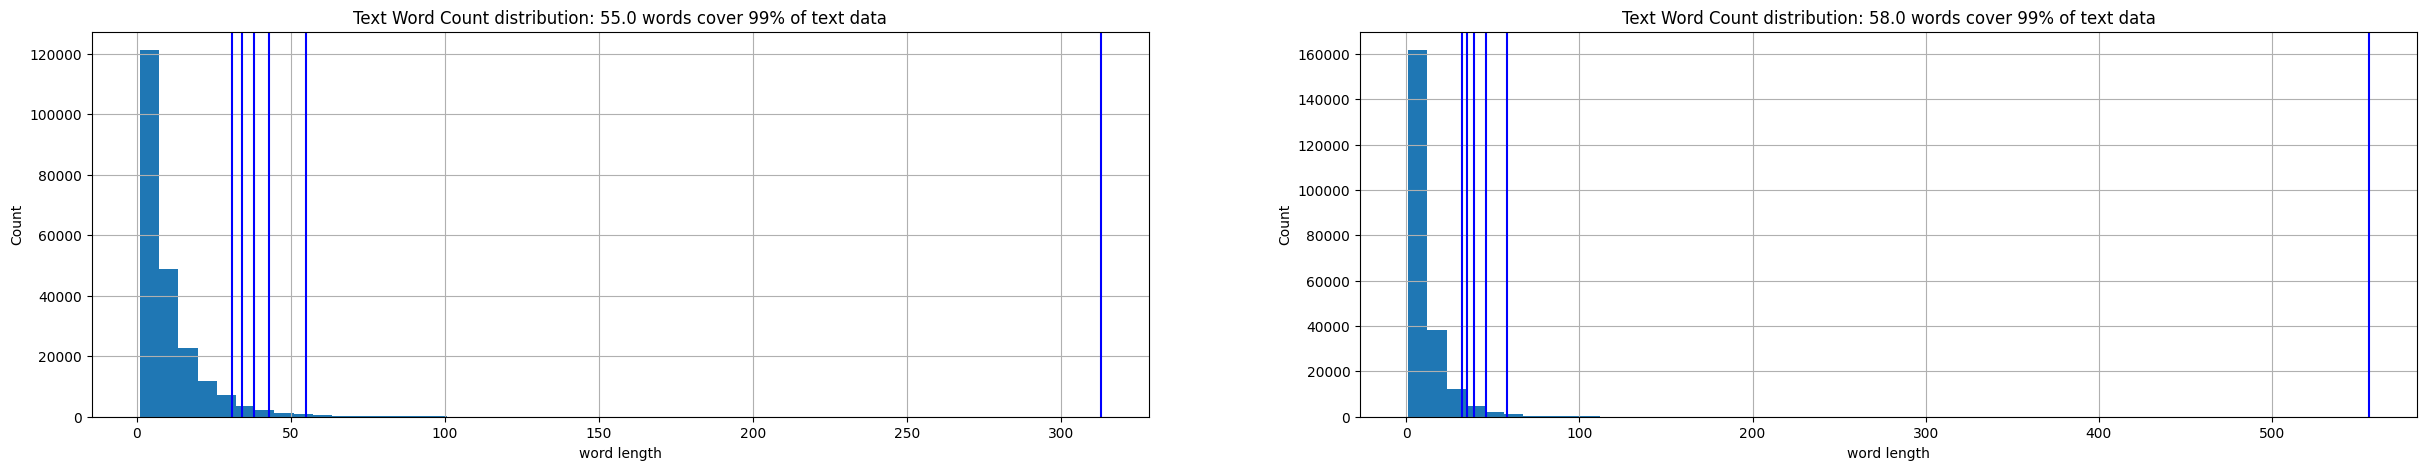

In [10]:
plt.figure(figsize = (30,5))

plt.subplot(1,2,1)
distplot_axis(data.col1_length)


plt.subplot(1,2,2)
distplot_axis(data.col2_length)

In [11]:
MAX_OUTPUT_LENGTH = 102
BATCH_SIZE = 32
UNITS = 64
EMBEDDING_DIMS = 128

# Splitting Data

In [33]:
if DEBUG:
    xtrain, xtest, ytrain, ytest = train_test_split(data['col1'],data['col2'], train_size=.05 , test_size=.005, random_state= 44)
else:
    xtrain, xtest, ytrain, ytest = train_test_split(data['col1'],data['col2'], test_size=.05, random_state= 44)

In [34]:
print(f'{xtrain.shape=}')
print(f'{ytrain.shape=}')
print(f'{xtest.shape=}')
print(f'{ytest.shape=}')

xtrain.shape=(210217,)
ytrain.shape=(210217,)
xtest.shape=(11065,)
ytest.shape=(11065,)


In [35]:
train_data = tf.data.Dataset.from_tensor_slices((xtrain.to_list(), ytrain.to_list()))
test_data = tf.data.Dataset.from_tensor_slices((xtest.to_list(), ytest.to_list()))

# Text Vectorization

In [36]:
# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text



In [38]:
# vectorization
vectorizer = TextVectorization(output_sequence_length=MAX_OUTPUT_LENGTH, standardize=tf_lower_and_split_punct_en)

In [39]:
for i,j in train_data.take(1):
    print(i)
    print(j)

tf.Tensor(b'is bending down, pulling a tray of sausage rolls into the oven. Both girls look at HONORA silently.', shape=(), dtype=string)
tf.Tensor(b'turns around and Juliet presents her with a brown paper bag.', shape=(), dtype=string)


In [40]:

# 20.2 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 21* 7 == 2 MIN 27 sec
vectorizer.adapt(xtrain)

### saving vectorizer
https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow


In [41]:
# Pickle the config and weights

# os.makedirs('components', exist_ok=True)
# pickle.dump({'config': vectorizer.get_config(),
#              'weights': vectorizer.get_weights()}
#             , open("./components/vectorizer.pkl", "wb"))


### Loading saved vectorizer

In [42]:
# Later you can unpickle and use 
# `config` to create object and 
# `weights` to load the trained weights. 

# from_disk = pickle.load(open("./components/vectorizer.pkl", "rb"))
# vectorizer = TextVectorization.from_config(from_disk['config'])
# # You have to call `adapt` with some dummy data (BUG in Keras)
# vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# vectorizer.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (vectorizer("who am i"))

tf.Tensor(
[  3  76 144   8   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(102,), dtype=int64)


In [69]:
def make_vector(x, y):
    x = vectorizer(x)
    y = vectorizer(y)

    x = x[:-1]
    y_in = y[:-1]
    y_out = y[1:]
    return (x,y_in),y_out

In [43]:
train_data = train_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Saving the Dataset

In [64]:
# %%timeit

save_train_data_path = './dataset/train/'
save_test_data_path = './dataset/test/'

# # save the train_data and test_data
# train_data.save(save_train_data_path, compression='GZIP')
# test_data.save(save_test_data_path, compression='GZIP')

In [66]:
# #loading the data
# train_datas = tf.data.Dataset.load(save_train_data_path, compression='GZIP')
# test_datas = tf.data.Dataset.load(save_test_data_path, compression='GZIP')

In [68]:
for (enc_input, dec_input), dec_output  in train_datas.take(1):
    print('encoder input')
    print(enc_input[0, :20].numpy())
    print('-'*44)
    print('decoder input')
    print(dec_input[0, :20].numpy()) 
    print('-'*44)
    print('encoder output')
    print(dec_output[0, :20].numpy())
    break

encoder input
[    3    20 10942   120     5  1994    11  6126    14  9357  5660   154
     9  7211     2   443   532   105    61 11786]
--------------------------------------------
decoder input
[   3 1361  174   13 3319 4872   69   39   11 1415  764  922    2    4
    0    0    0    0    0    0]
--------------------------------------------
encoder output
[1361  174   13 3319 4872   69   39   11 1415  764  922    2    4    0
    0    0    0    0    0    0]


# Encoder

In [70]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_vectorizer, units, embed_dims):
        super(Encoder, self).__init__()
        self.text_vectorizer =  text_vectorizer
        self.units = units
        self.embed_dims = embed_dims
        self.vocab_size = text_vectorizer.vocabulary_size()
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dims, mask_zero=True, )
        self.rnn = Bidirectional(merge_mode='concat', layer = GRU(self.units, return_sequences=True, return_state=True))
        
    def call(self, x, y=None, return_state=False):
        
        x = self.embedding(x)
        encoder_output, encoder_fw_state, encoder_bw_state = self.rnn(x)
        encoder_state = [encoder_fw_state, encoder_bw_state]
        
        if return_state:
            return encoder_output, encoder_state
        else:
            return encoder_output
        
    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_vectorizer(texts)
        context = self(context)
        return context

In [71]:
encoder = Encoder(vectorizer, UNITS, EMBEDDING_DIMS)

In [72]:
en_context , en_state = encoder(enc_input, return_state = True)

In [73]:
print('context',en_context.shape)
print('state fw',en_state[0].shape)
print('state bw',en_state[1].shape)

context (32, 101, 128)
state fw (32, 64)
state bw (32, 64)


# Attention Layer

In [74]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [75]:
# attention = tf.keras.layers.Attention()
# score = attention([en_context, en_context], return_attention_scores=True)

In [76]:
attention = CrossAttention(UNITS)
score = attention(en_context, en_context)

In [77]:
if len(score)==2:
    print(score[0].shape);print(score[1].shape)
else:
    print(score.shape)

(32, 101, 128)


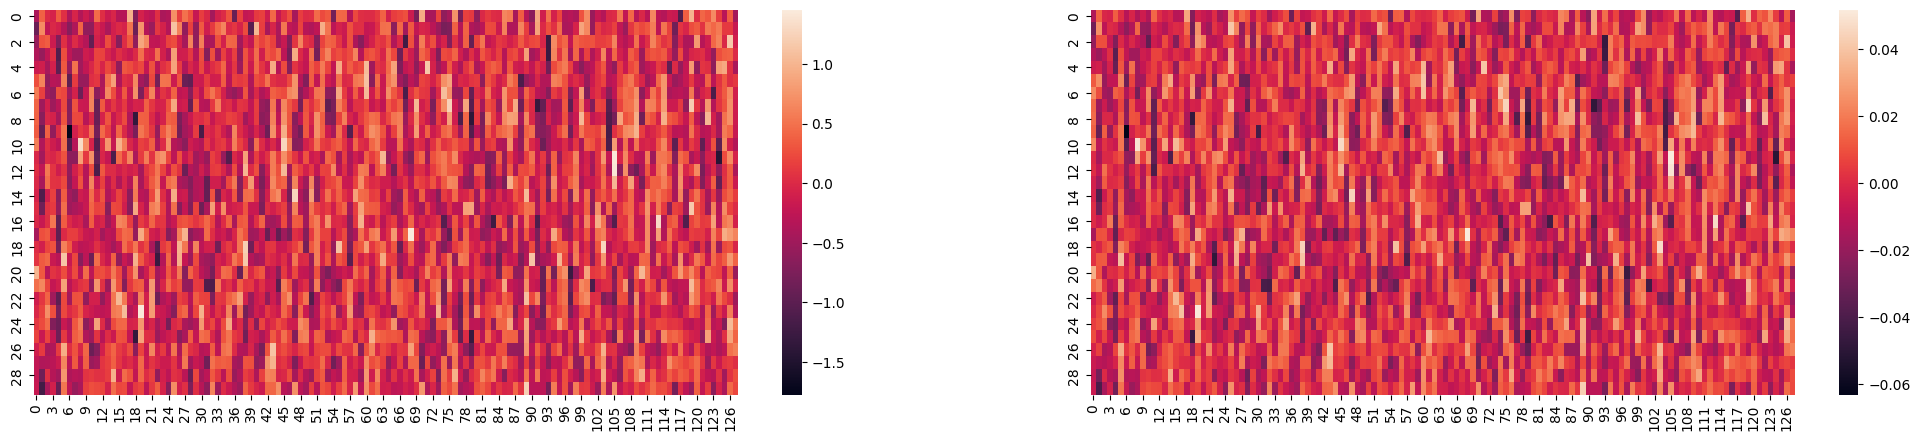

In [78]:
# score[0,:,:], en_context[0,:,:]
random_num = random.randint(0,32)
plt.figure(figsize = (25,5))

try:
    plt.subplot(1,2,1)
    sns.heatmap(score[random_num,:30,:])

#     # attention score
#     plt.subplot(1,3,2)
#     sns.heatmap(score[1][random_num,:30,:])

    # encoder output
    plt.subplot(1,2,2)
    sns.heatmap(en_context[random_num,:30,:])
    
except:
    pass

# Decoder

In [79]:
class Decoder(keras.layers.Layer):
    def __init__(self, text_vectorizer, units,  embed_dims) :
        super(Decoder, self).__init__()
        self.text_vectorizer =  text_vectorizer
        self.units = units
        self.embed_dims = embed_dims
        self.vocab_size = text_vectorizer.vocabulary_size()
        
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dims, mask_zero=True, )
        self.rnn = LSTM(self.units, return_sequences=True, return_state=True)
        
        # self.attention =  tf.keras.layers.Attention()
        self.attention = CrossAttention(units)
        
        self.output_dense = Dense(self.vocab_size)
        
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

    def call(self, x, context, state=None, return_state = False):
        ''' x, context, state=None, return_sequence=False '''
        
        x = self.embedding(x)
        
        decoder_output, decoder_state_h, decoder_state_c = self.rnn(x, initial_state=state)
        
        decoder_state = [decoder_state_h, decoder_state_c]
        x = self.attention(decoder_output, context)
        self.last_attention_weights = self.attention.last_attention_weights

        logits = self.output_dense(x)
        
        if return_state:
            return logits, decoder_state
        else:
            return logits
        
    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    
    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result
    
    def get_next_token(self, next_token, context,  done, state, temperature = 0.0):
        
        logits, state = self(next_token, context, state = state, return_state=True) 

        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [80]:
decoder = Decoder(vectorizer, UNITS, EMBEDDING_DIMS)

In [81]:
dec_out = decoder(dec_output, en_context, return_state = True)

In [82]:
print(f'decoder logits shape: {dec_out[0].shape}')
print(f'decoder state h shape: {dec_out[1][0].shape}')
print(f'decoder state c shape: {dec_out[1][1].shape}')

decoder logits shape: (32, 101, 49580)
decoder state h shape: (32, 64)
decoder state c shape: (32, 64)


# Model

In [83]:
class ChatBot(tf.keras.Model):
    
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, embed_dims):
        super().__init__()
        self.text_processor = text_processor
        self.units = units
        self.embed_dims = embed_dims
        
        # Build the encoder and decoder
        encoder = Encoder(text_processor, units, embed_dims)
        decoder = Decoder(text_processor, units, embed_dims)
        
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(x, context)

        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits


In [84]:
model = ChatBot(vectorizer, UNITS, EMBEDDING_DIMS)

# logits = model((enc_input, dec_input))

# print(f'Context tokens, shape: (batch, s, units) {enc_input.shape}')
# print(f'Target tokens, shape: (batch, t) {dec_input.shape}')
# print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

# Masked Loss and Accuracy

In [85]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [86]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Compile and Train

In [87]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [88]:
# The model is randomly initialized, and should give roughly uniform output probabilities. 
# So it's easy to predict what the initial values of the metrics should be:


vocab_size = 1.0 * vectorizer.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": f'{1/vocab_size:.7f}'}

{'expected_loss': 10.811343, 'expected_acc': '0.0000202'}

In [89]:
# model.evaluate(test_data, steps=20, return_dict=True)

In [91]:
EPOCHS = 50

CKPT_DIR = './model_checkpoint'

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR,  f"{datetime.now().strftime('%m:%d:%Y, %H:%M:%S')}"),
    monitor= 'masked_acc',
    verbose= 0,
    save_best_only = True,
    save_weights_only = True,
    mode= 'auto',
    save_freq='epoch'
)

In [92]:
# Train
history = model.fit(
    train_data.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = 80,
    validation_data=test_data,
    validation_steps = 5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3), model_ckpt])

Epoch 1/50


2023-02-25 20:29:50.496338: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	while inferring type of node 'cond_43/output/_20'
2023-02-25 20:30:01.019148: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 611.28MiB (rounded to 640970240)requested by op masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
If the cause is memory fragmentation maybe the environment va

ResourceExhaustedError: Graph execution error:

Detected at node 'masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/t/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/home/t/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10346/1630762766.py", line 2, in <module>
      history = model.fit(
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/tmp/ipykernel_10346/2953002845.py", line 5, in masked_loss
      loss = loss_fn(y_true, y_pred)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/keras/backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
OOM when allocating tensor with shape[3232,49580] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_127924]